In [13]:
library("ggplot2")

# Problem 11: Flat Bayesian priors

Many reactions, including between biomolecules involved in cell signaling, gene expression, obey simple chemical reaction where the amount of active molecule is given by

$$\frac{dx}{dt} = k_{\textrm{on}} - k_{\textrm{off}} x$$

and often there is measurement noise 

$$y = x + \epsilon$$

where $\epsilon$ is Gaussian distributed with standard deviation $\sigma$.



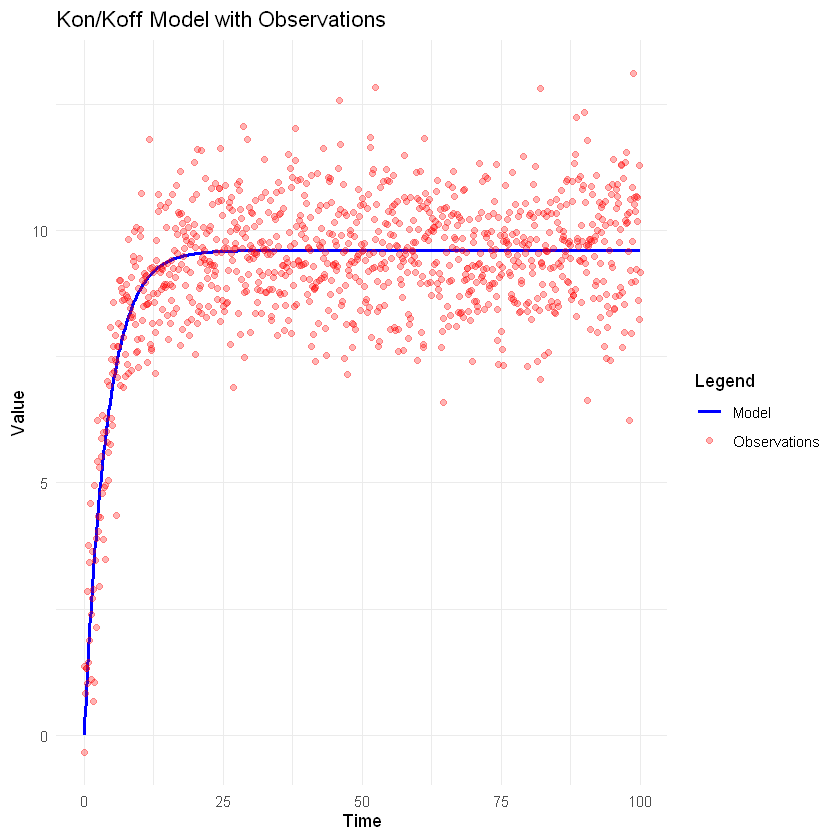

In [14]:
# Generate synthetic data
set.seed(42)
# Let's simulate the reaction

# solution to first-order kinetics

NSample = 1000 # sample size
sigma_gt <- 1 # observation noise

# parametrize by kon and koff

kon_gt <- 2.4
koff_gt <- 0.25


tStart <- 0
tStop <- 100
times <- seq(from=tStart,to=tStop,by=(tStop-tStart)/(NSample-1))


x <- kon_gt/koff_gt*(1-exp(-koff_gt*times))
soln <- data.frame( "x"=x, "times"=times)

# add noise
y <- x + rnorm(NSample,0,sigma_gt)
soln$observations = y

# Create the plot
ggplot(soln, aes(x=times)) +
  geom_line(aes(y=x, color="Model"), linewidth=1) +
  geom_point(aes(y=observations, color="Observations"), alpha=0.3) +
  labs(title="Kon/Koff Model with Observations",
       x="Time",
       y="Value",
       color="Legend") +
  scale_color_manual(values=c("Model"="blue", "Observations"="red")) +
  theme_minimal()


Given time series data of $x(t)$, we will try to discover the values of paramaters ``kon``, ``koff`` and ``sigma`` using Markov Chain Monte Carlo (MCMC).

To perform MCMC, we must choose priors.
We make the simplest assumption and use flat priors, subject to non-negativity (we require kon>0, koff>0 and sigma>0). 

Below is a code snippet that implements MCMC to learn the parameters of the model. 

In [15]:
# define the likelihood function

logLikelihood <- function(param,times,y){
    kon = param[1]
    koff = param[2]
    sigma = param[3]
    
    pred = kon/koff*(1-exp(-koff*times))

    singleLikelihoods = dnorm(y, mean=pred, sd=sigma, log=T) # really the log likelihood
    sumLikelihood = sum(singleLikelihoods) # really the log of the product of likelihoods
        
    return(sumLikelihood)
    
}

# Here is the Metropolis algorithm

proposalGenerator <- function(currentParam){
    
    proposalParam = rnorm(3, mean=currentParam, sd = c(0.02,0.002,0.01)) 
    # play with these to make the acceptance rates around 30% for most efficient MCMC
    proposalParam[proposalParam<0] <- 0 # Prevent negative values
    return(proposalParam)
}

run_metropolis_MCMC <- function(startvalue, iterations){
    chain = array(dim = c(iterations+1,3))
    chain[1,] = startvalue
    for (i in 1:iterations){
        
        proposal = proposalGenerator(chain[i,])
         
        # This is the Metropolis-Hastings ("Boltzmann") test
        probab = exp(logLikelihood(proposal,times,y) - logLikelihood(chain[i,],times,y))    
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }
        else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}


The code block below runs the MCMC algorithm.
Note: depending on the number of iterations, this could take several minutes on your computer. 

In [16]:
set.seed(42)
startvalue = c(1,0.1,0.1)
iterations = 100000

# Run the MCMC learning
# Note: This is a long run, so you may want to reduce the number of iterations for testing
chain = run_metropolis_MCMC(startvalue, iterations)
 
burnIn = 10000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))
cat("Acceptance rate: ", acceptance, "\n")

Acceptance rate:  0.3189298 


## Question i

The output of MCMC is a sample of values of the parameters $k_{\textrm on}$, $k_{\textrm{off}}$ and $\sigma$ that represent the posterior distribution.

Plot the sequence of parameter values.
What is the acceptance rate?
Does it look converged? If not, adjust the MCMC hyperparameters and repeate the learning run.

# Answer i
- The acceptance rate is ~32%
- The sequence looks converged

Acceptance rate:  0.3189298 


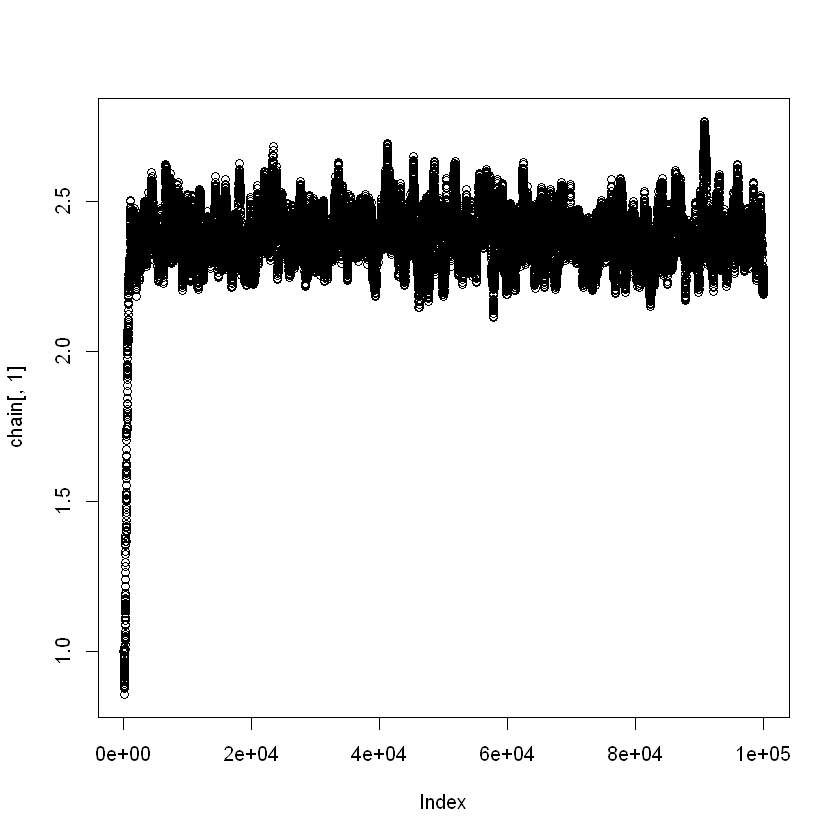

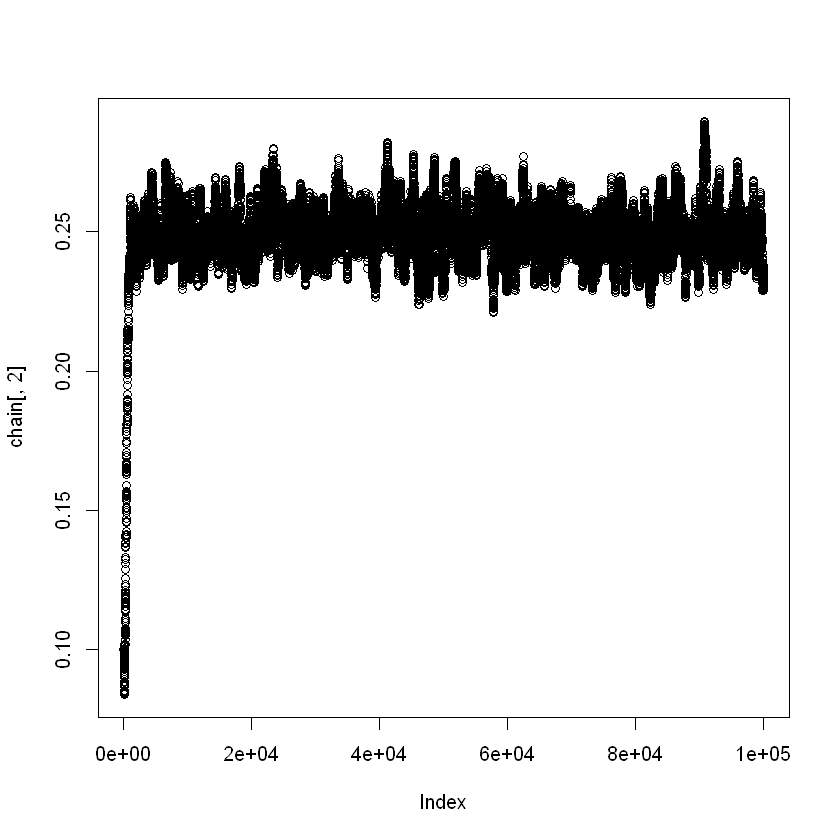

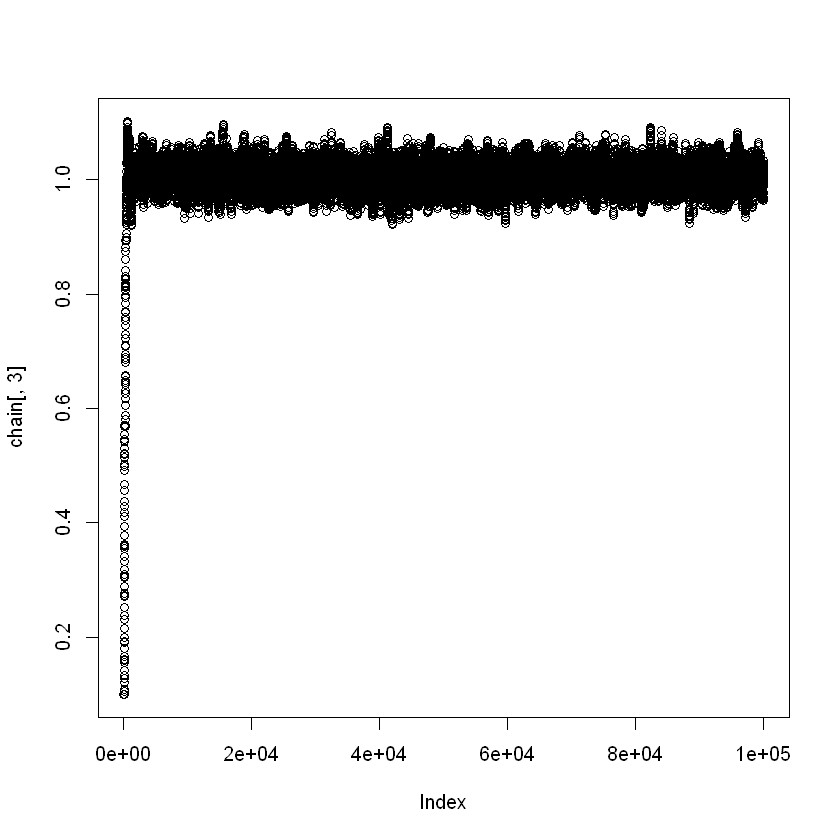

In [17]:
cat("Acceptance rate: ", acceptance, "\n")

par(bg = "white")
plot(chain[,1])
plot(chain[,2])
plot(chain[,3])

Plot the 3 histograms of $k_{\textrm{on}}$, koff and sigma. Add an indicator at the ground truth value.

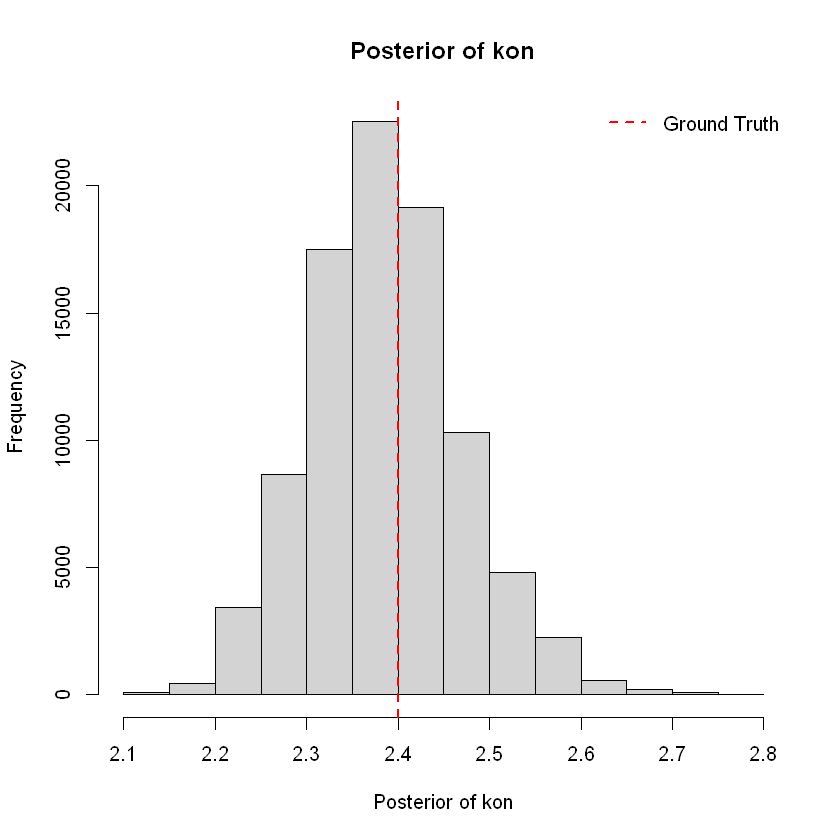

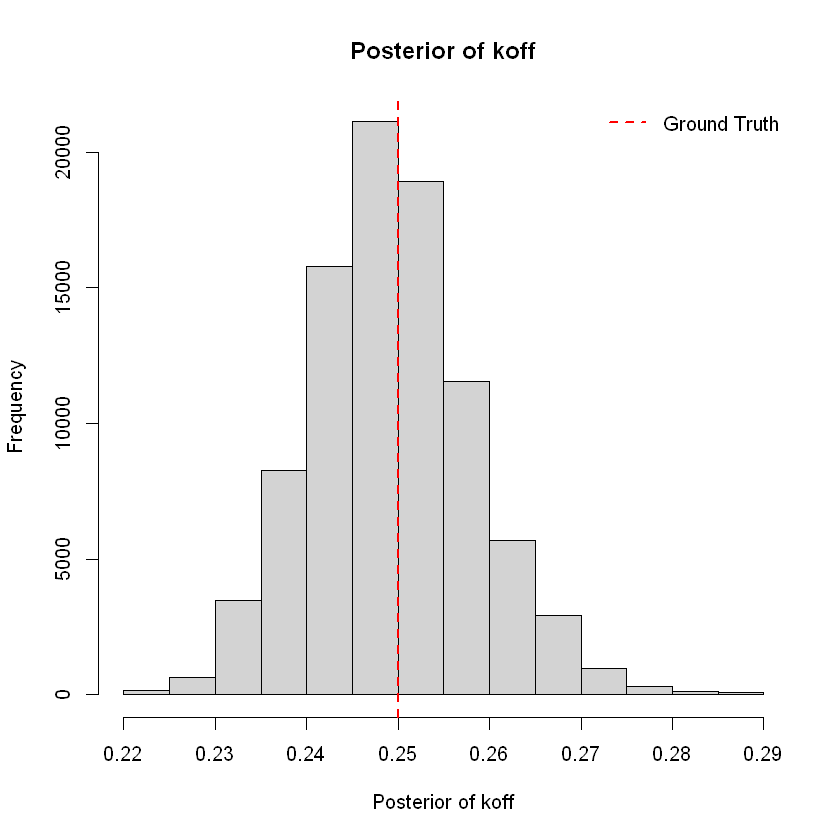

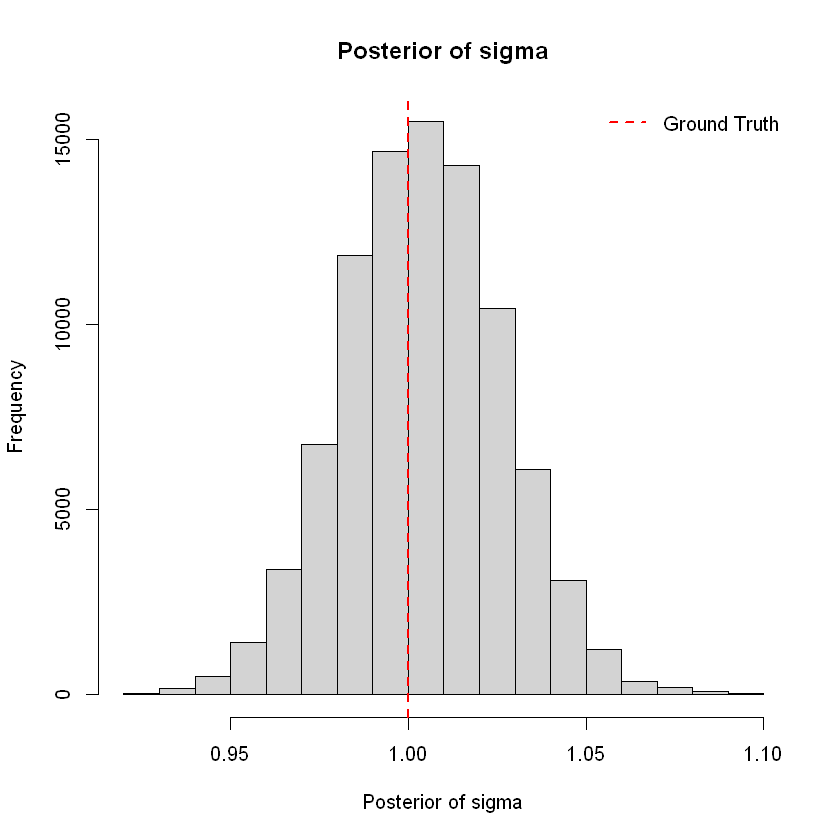

In [18]:
# Plot the sequence of parameter values
par(bg = "white")

# kon
hist(chain[-(1:burnIn), 1], xlab = "Posterior of kon", main = "Posterior of kon")
abline(v = kon_gt, col = "red", lwd = 2, lty = 2)
legend("topright", legend = "Ground Truth", col = "red", lwd = 2, lty = 2, bty = "n")

# koff
hist(chain[-(1:burnIn), 2], xlab = "Posterior of koff", main = "Posterior of koff")
abline(v = koff_gt, col = "red", lwd = 2, lty = 2)
legend("topright", legend = "Ground Truth", col = "red", lwd = 2, lty = 2, bty = "n")

# sigma
hist(chain[-(1:burnIn), 3], xlab = "Posterior of sigma", main = "Posterior of sigma")
abline(v = sigma_gt, col = "red", lwd = 2, lty = 2)
legend("topright", legend = "Ground Truth", col = "red", lwd = 2, lty = 2, bty = "n")

Plot 3 two-dimensional histgrams of each pair of parameters. Add an indicator at the ground truth value.

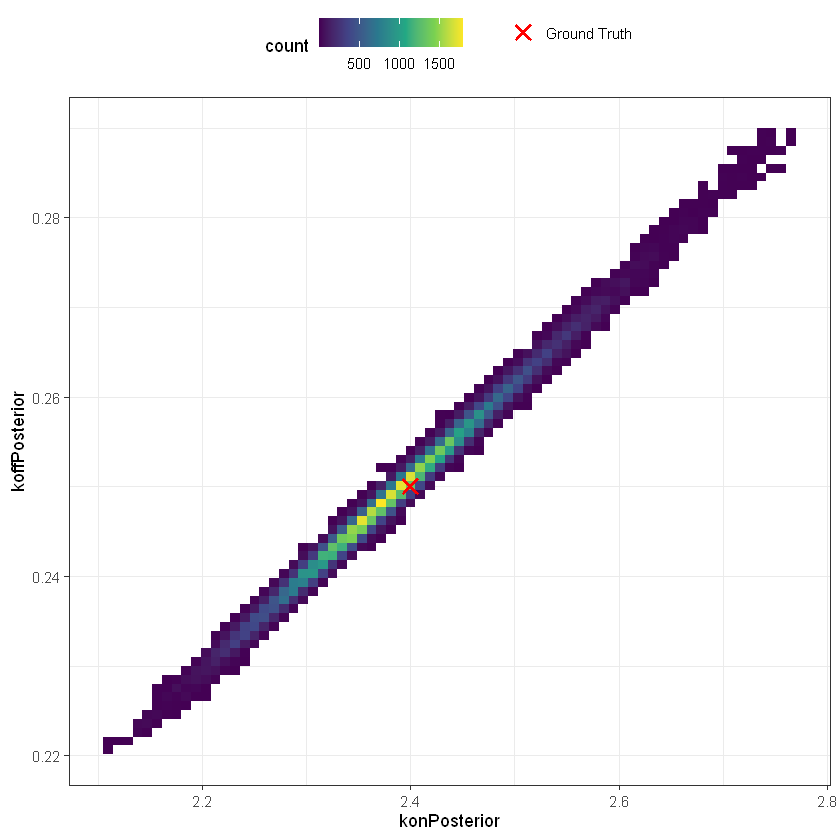

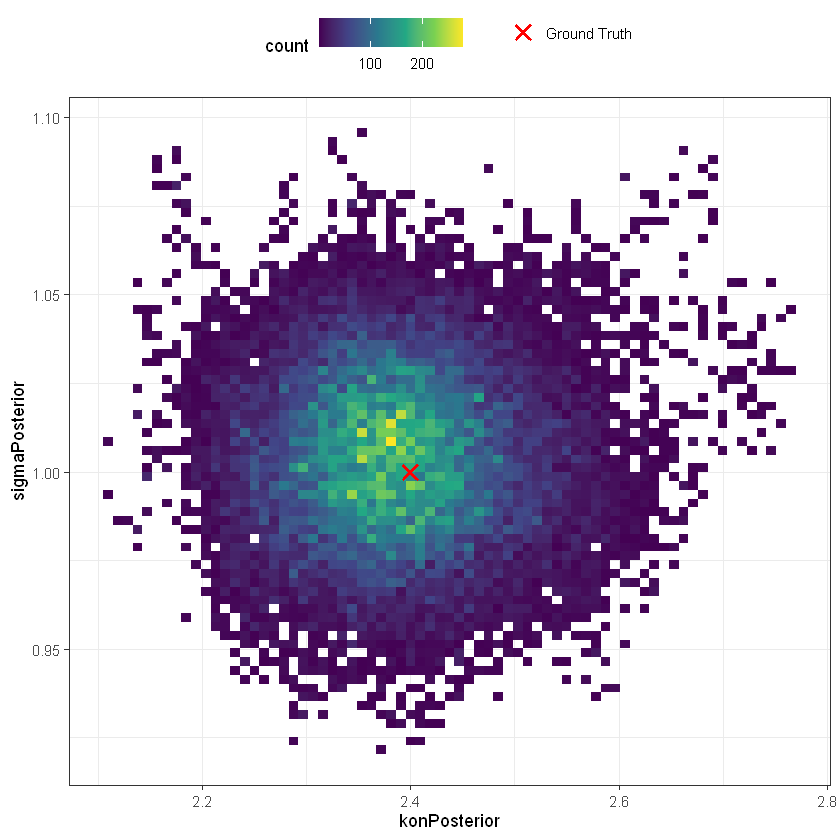

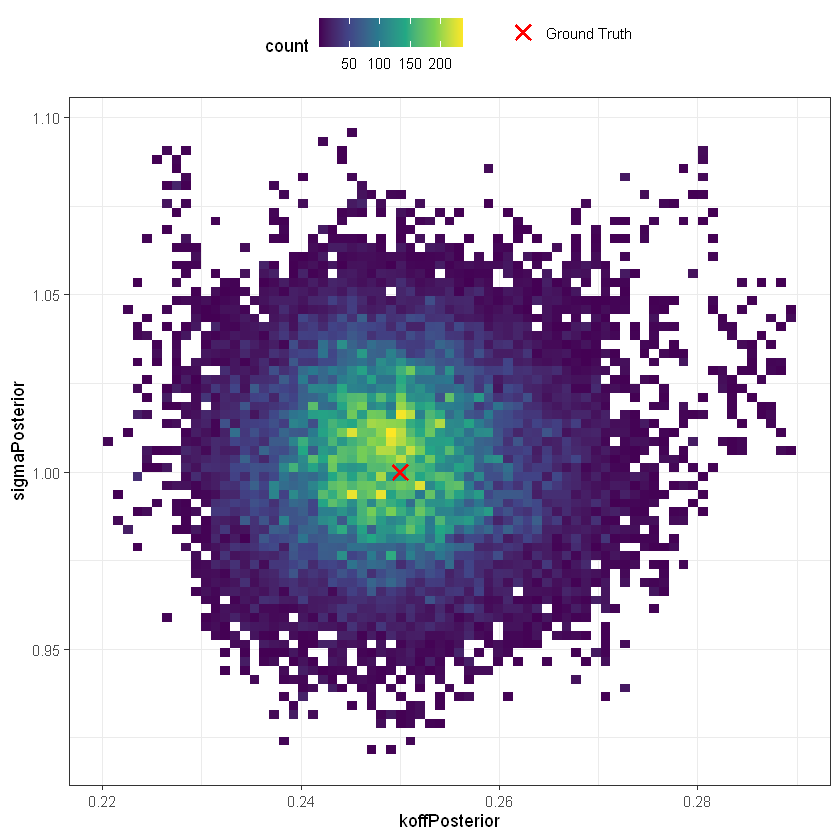

In [19]:
df_eq1 <- data.frame(konPosterior=chain[-(1:burnIn),1], 
                      koffPosterior=chain[-(1:burnIn),2],
                      sigmaPosterior=chain[-(1:burnIn),3] )

# Prepare ground truth data as a small data frame
gt_df <- data.frame(kon = kon_gt, koff = koff_gt, sigma = sigma_gt)

# kon vs koff
ggplot(df_eq1, aes(x = konPosterior, y = koffPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = kon, y = koff, color = "Ground Truth"), 
             shape = 4, size = 3, stroke = 1.5) +
  scale_color_manual(name = "", values = c("Ground Truth" = "red")) +
  theme_bw() +
  theme(legend.position = "top")

# kon vs sigma
ggplot(df_eq1, aes(x = konPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = kon, y = sigma, color = "Ground Truth"), 
             shape = 4, size = 3, stroke = 1.5) +
  scale_color_manual(name = "", values = c("Ground Truth" = "red")) +
  theme_bw() +
  theme(legend.position = "top")

# koff vs sigma
ggplot(df_eq1, aes(x = koffPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = koff, y = sigma, color = "Ground Truth"), 
             shape = 4, size = 3, stroke = 1.5) +
  scale_color_manual(name = "", values = c("Ground Truth" = "red")) +
  theme_bw() +
  theme(legend.position = "top")


## Question ii

The chemical reaction we simulated is mathematically identical to 

$$\frac{dx}{dt} = \frac{1}{\tau}\left( K_A -  x \right)$$

where $\tau$ is the timescale of the reaction and $K_A$ is the affinity. 
(Aside: another often-discussed quantity is the dissociation constant $K_D = 1/K_A$.) 

Show that the chemical reaction with $K_D$ and $\tau$ is identical to the first one with $k_{\rm on}$ and $k_{\rm off}$. Find the relationship between the two sets of parameters.

# Answer ii

$$\frac{dx}{dt} = k_{\textrm{on}} - k_{\textrm{off}} x$$
$$\frac{dx}{dt} = \frac{1}{\tau}\left(K_A - x\right) = \frac{K_A}{\tau} -\frac{1}{\tau}x$$
Assuming that the two systems are equal, we the relationships between the two sets of parameters as:
$$k_{\textrm{off}}=\frac{1}{\tau} \implies\tau = \frac{1}{k_\textrm{off}}$$
$$k_{\textrm{on}} = \frac{K_A}{\tau} = K_A\times k_{\textrm{off}}\implies K_A = \frac{k_{\textrm{on}}}{k_{\textrm{off}}}$$


## Question iii

In this problem, we will MCMC to fit the simulated data to discover the values of paramaters ``KD``, ``tau`` and ``sigma`` (the same as above, the standard deviation of the observational noise).

To perform MCMC, we must choose priors. We make the simplest assumption and use flat priors, subject to non-negativity (we require KD>0, tau>0 and sigma>0). 

Edit the MCMC code to perform MCMC learning to the equation with K_A, tau and sigma.

Make the same plots as in Question i:

* Plot the sequence of parameter values. Does it look converged? If not, adjust the MCMC hyperparameters and repeate the learning run.

* Plot the 3 histograms of $\tau$, K_A and sigma. Add an indicator at the ground truth value.

* Plot 3 two-dimensional histgrams of each pair of parameters. 



# Answer iii
First we have to solve the differential equation:
$$\frac{dx}{dt} = \frac{1}{\tau}(K_A - x)$$
$$\frac{dx}{dt} + \frac{1}{\tau} x = \frac{1}{\tau} K_A$$
This is a first-order linear ODE of the form:
$$\frac{dx}{dt} + P(t)x = Q(t)$$
with $P(t) = \frac{1}{\tau}$, $Q(t) = \frac{1}{\tau}K_A$
The integrating factor is:
$$\mu(t) = e^{\int \frac{1}{\tau} dt} = e^{t/\tau}$$
Multiplying both sides by the integrating factor:
$$e^{t/\tau} \frac{dx}{dt} + \frac{1}{\tau} e^{t/\tau} x = \frac{1}{\tau} K_A e^{t/\tau}$$

The left-hand side is the derivative of the product:
$$\frac{d}{dt}\left(x e^{t/\tau} \right) = \frac{1}{\tau} K_A e^{t/\tau}$$
Integrating both sides:
$$\int \frac{d}{dt}\left(x e^{t/\tau} \right) dt = \int \frac{1}{\tau} K_A e^{t/\tau} dt$$
$$x e^{t/\tau} = K_A e^{t/\tau} + C$$
$$x(t) = K_A + C e^{-t/\tau}$$
Setting $x(0) = 0$
$$x(0) = K_A + C \Rightarrow C = -K_A$$
$$\boxed{x(t) = K_A(1 - e^{-t/\tau})}$$

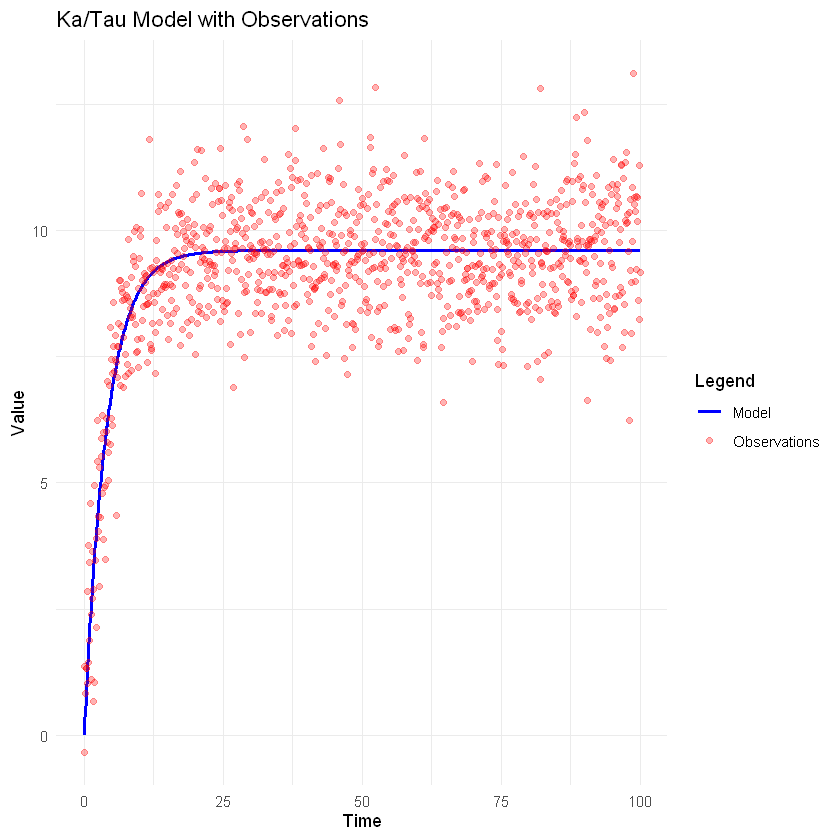

In [20]:
# Generate synthetic data for second equation
set.seed(42)
# Let's simulate the reaction

# solution to first-order kinetics

NSample = 1000 # sample size
sigma_gt <- 1 # observation noise

# parametrize by ka and tau
kon_gt <- 2.4
koff_gt <- 0.25
ka_gt <- kon_gt/koff_gt
tau_gt <- 1/koff_gt

tStart <- 0
tStop <- 100
times <- seq(from=tStart,to=tStop,by=(tStop-tStart)/(NSample-1))

x <- ka_gt*(1-exp(-times/tau_gt))
soln <- data.frame( "x"=x, "times"=times)

# add noise
y <- x + rnorm(NSample,0,sigma_gt)
soln$observations = y

# Create the plot
ggplot(soln, aes(x=times)) +
  geom_line(aes(y=x, color="Model"), linewidth=1) +
  geom_point(aes(y=observations, color="Observations"), alpha=0.3) +
  labs(title="Ka/Tau Model with Observations",
       x="Time",
       y="Value",
       color="Legend") +
  scale_color_manual(values=c("Model"="blue", "Observations"="red")) +
  theme_minimal()


Next we develop a MCMC model for predicting the ground truth values

Acceptance rate:  0.3527294 


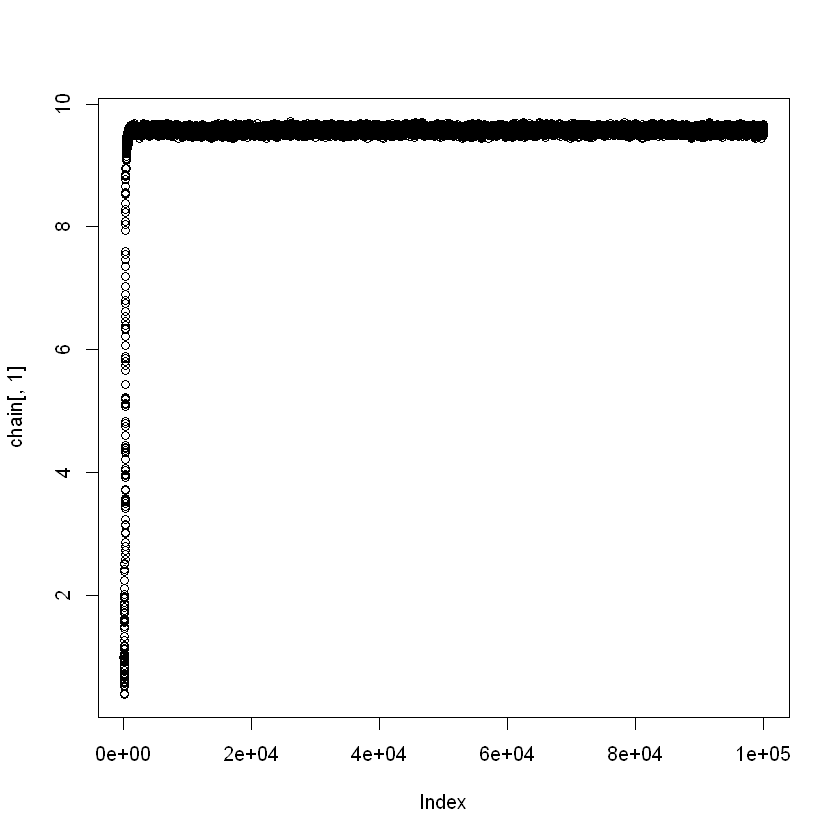

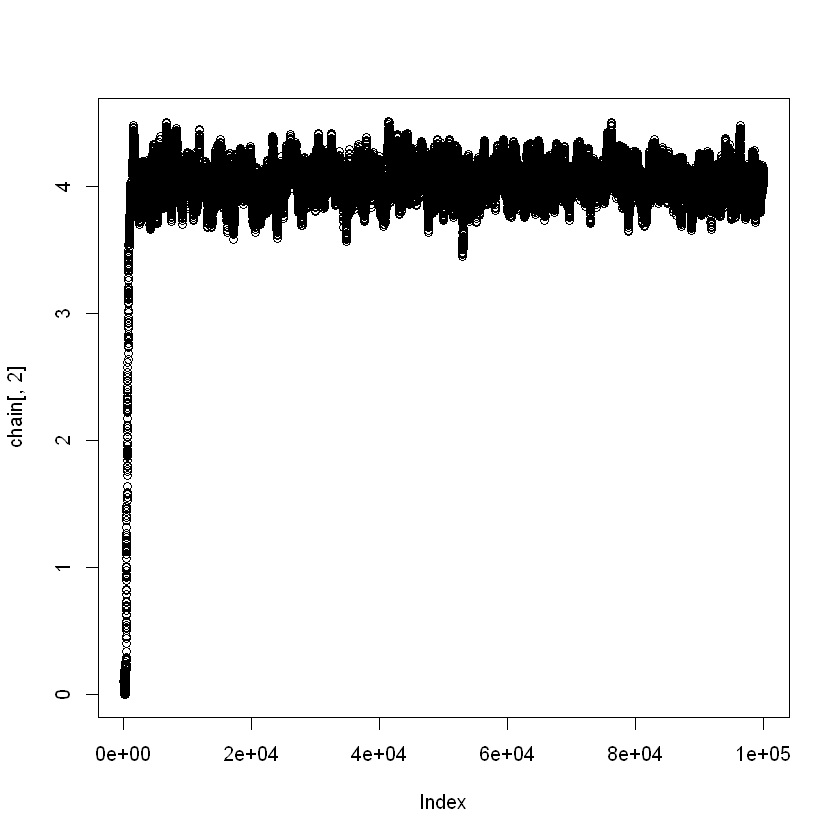

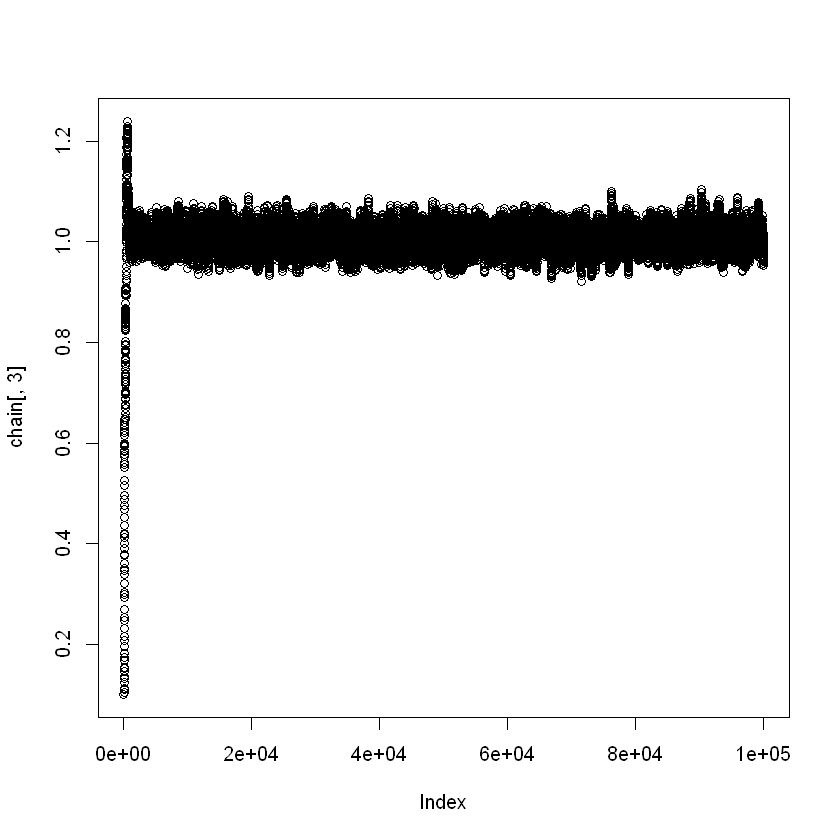

In [21]:
# define the likelihood function

logLikelihood <- function(param,times,y){
    ka = param[1]
    tau = param[2]
    sigma = param[3]
    
    pred =  ka*(1-exp(-times/tau))

    singleLikelihoods = dnorm(y, mean=pred, sd=sigma, log=T) # really the log likelihood
    sumLikelihood = sum(singleLikelihoods) # really the log of the product of likelihoods
        
    return(sumLikelihood)
    
}

# Here is the Metropolis algorithm

proposalGenerator <- function(currentParam){
    
    proposalParam = rnorm(3, mean=currentParam, sd = c(0.0975,0.025,0.01))
    # play with these to make the acceptance rates around 30% for most efficient MCMC
    proposalParam[proposalParam<0] <- 1e-10 # Prevent negative values
    return(proposalParam)
}

run_metropolis_MCMC <- function(startvalue, iterations){
    chain = array(dim = c(iterations+1,3))
    chain[1,] = startvalue
    for (i in 1:iterations){
        
        proposal = proposalGenerator(chain[i,])
         
        # This is the Metropolis-Hastings ("Boltzmann") test
        probab = exp(logLikelihood(proposal,times,y) - logLikelihood(chain[i,],times,y))    
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }
        else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}
set.seed(42)
startvalue = c(1,0.1,0.1)
iterations = 100000

# Run the MCMC learning
chain = run_metropolis_MCMC(startvalue, iterations)
 
burnIn = 10000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))
cat("Acceptance rate: ", acceptance, "\n")

par(bg = "white")
plot(chain[,1])
plot(chain[,2])
plot(chain[,3])

We move forward with the following data as the plots look like the sequences have converged, with an acceptance rate of around ~35%. We move to plot the three histograms of $K_A, \tau, \text{ and }\sigma$

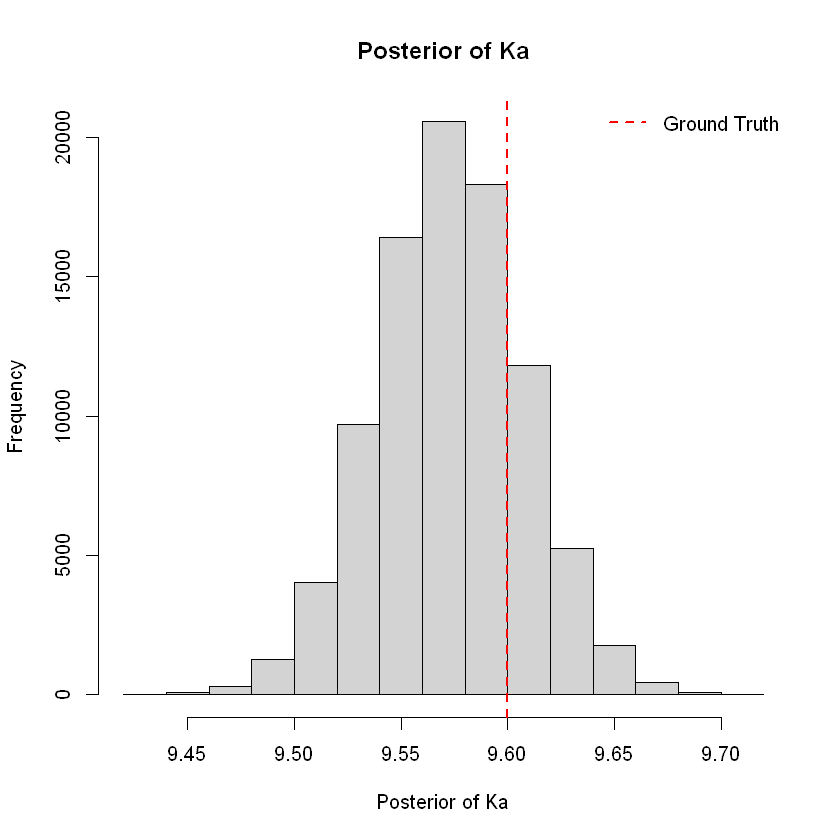

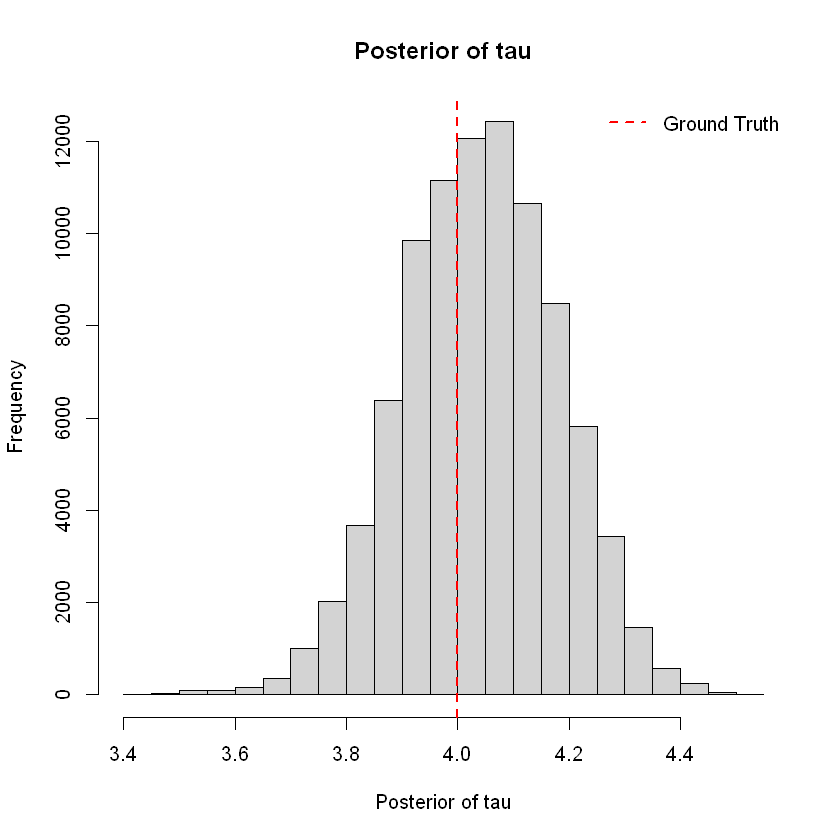

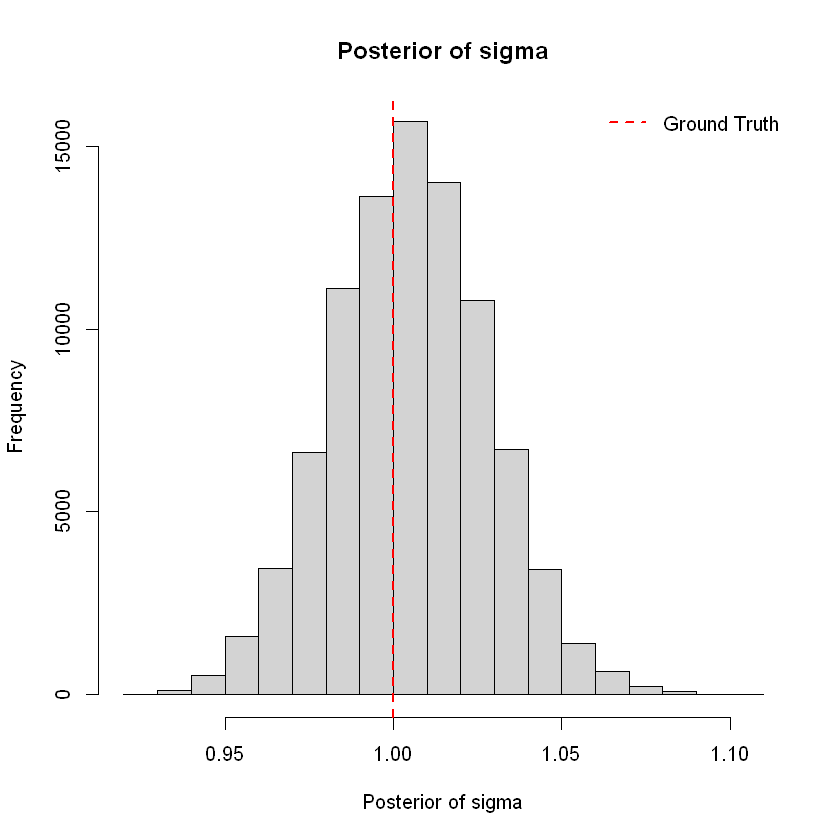

In [22]:
# Plot the sequence of parameter values
par(bg = "white")

# kon
hist(chain[-(1:burnIn), 1], xlab = "Posterior of Ka", main = "Posterior of Ka")
abline(v = ka_gt, col = "red", lwd = 2, lty = 2)
legend("topright", legend = "Ground Truth", col = "red", lwd = 2, lty = 2, bty = "n")

# koff
hist(chain[-(1:burnIn), 2], xlab = "Posterior of tau", main = "Posterior of tau")
abline(v = tau_gt, col = "red", lwd = 2, lty = 2)
legend("topright", legend = "Ground Truth", col = "red", lwd = 2, lty = 2, bty = "n")

# sigma
hist(chain[-(1:burnIn), 3], xlab = "Posterior of sigma", main = "Posterior of sigma")
abline(v = sigma_gt, col = "red", lwd = 2, lty = 2)
legend("topright", legend = "Ground Truth", col = "red", lwd = 2, lty = 2, bty = "n")

Next we plot the three 2D histograms for the following MCMC predictions.

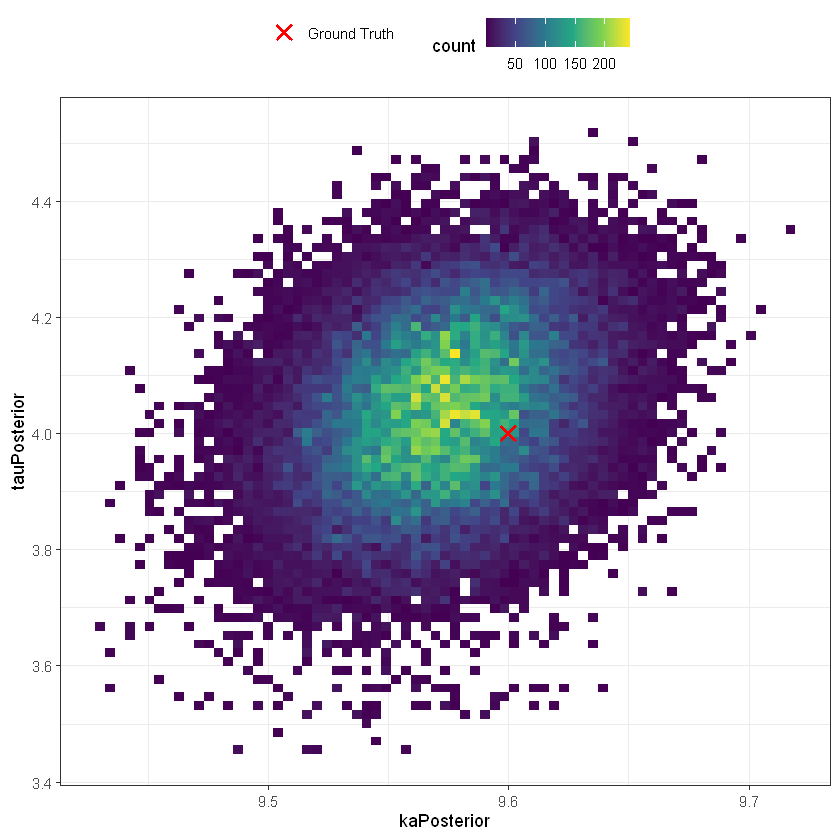

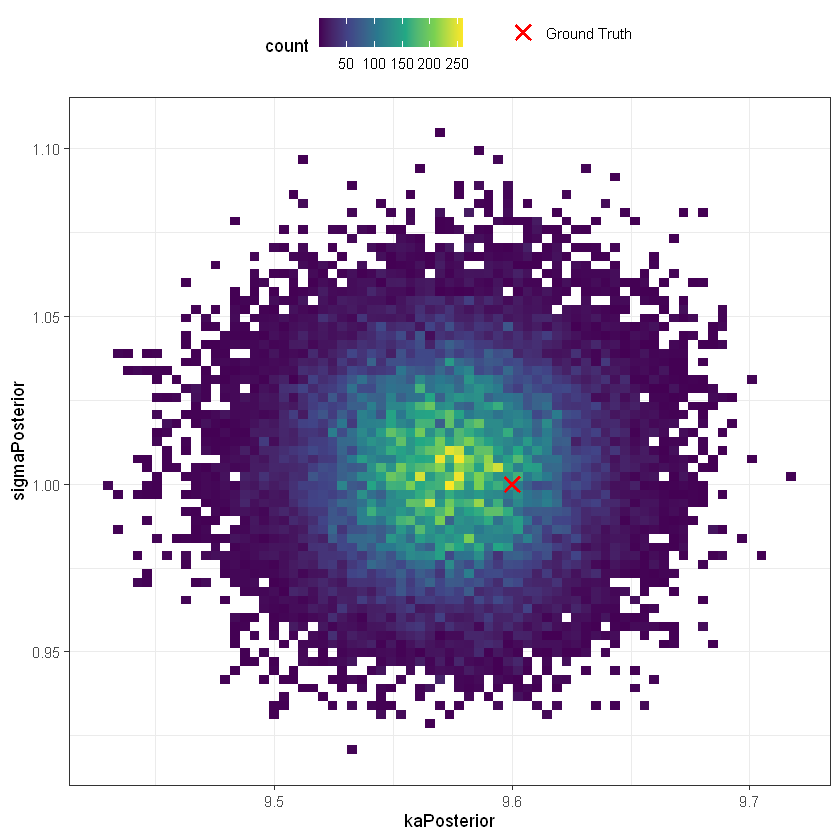

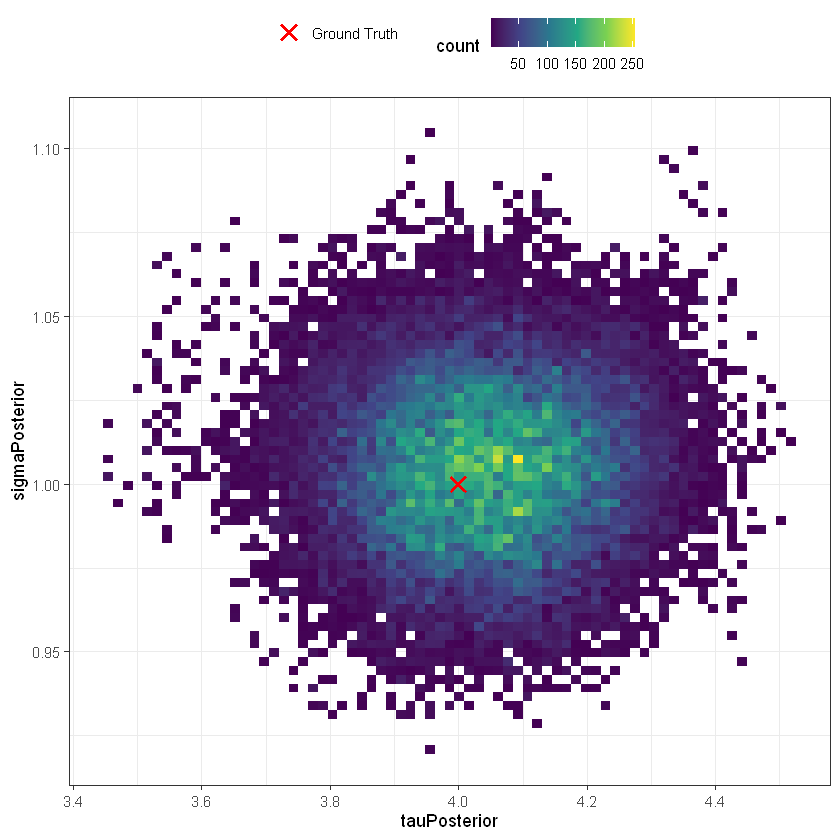

In [23]:
df_eq2 <- data.frame(kaPosterior=chain[-(1:burnIn),1], 
                      tauPosterior=chain[-(1:burnIn),2],
                      sigmaPosterior=chain[-(1:burnIn),3] )

# Prepare ground truth data as a small data frame
gt_df <- data.frame(ka = ka_gt, tau = tau_gt, sigma = sigma_gt)

# ka vs tau
ggplot(df_eq2, aes(x = kaPosterior, y = tauPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = ka, y = tau, color = "Ground Truth"), 
             shape = 4, size = 3, stroke = 1.5) +
  scale_color_manual(name = "", values = c("Ground Truth" = "red")) +
  theme_bw() +
  theme(legend.position = "top")

# ka vs sigma
ggplot(df_eq2, aes(x = kaPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = ka, y = sigma, color = "Ground Truth"), 
             shape = 4, size = 3, stroke = 1.5) +
  scale_color_manual(name = "", values = c("Ground Truth" = "red")) +
  theme_bw() +
  theme(legend.position = "top")

# tau vs sigma
ggplot(df_eq2, aes(x = tauPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = tau, y = sigma, color = "Ground Truth"), 
             shape = 4, size = 3, stroke = 1.5) +
  scale_color_manual(name = "", values = c("Ground Truth" = "red")) +
  theme_bw() +
  theme(legend.position = "top")


## Question iv

Take the posterior sample from Question iii and transform these to $koff$ and $kon$. 

Plot the 3 histograms of $koff$ and $kon$ and $sigma$, and the 3 two-dimensional histograms of pairs of parameters.
Compare these to question i. 

Which posterior estimates have a tighter distribution?
Which posterior estimates are closer to the ground truth?


# Answer iv

In [28]:
if (!requireNamespace("patchwork", quietly = TRUE)) {
  install.packages("patchwork")
}
library(patchwork)

Installing package into 'C:/Users/dasha/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'patchwork' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\dasha\AppData\Local\Temp\Rtmp6NhaYm\downloaded_packages


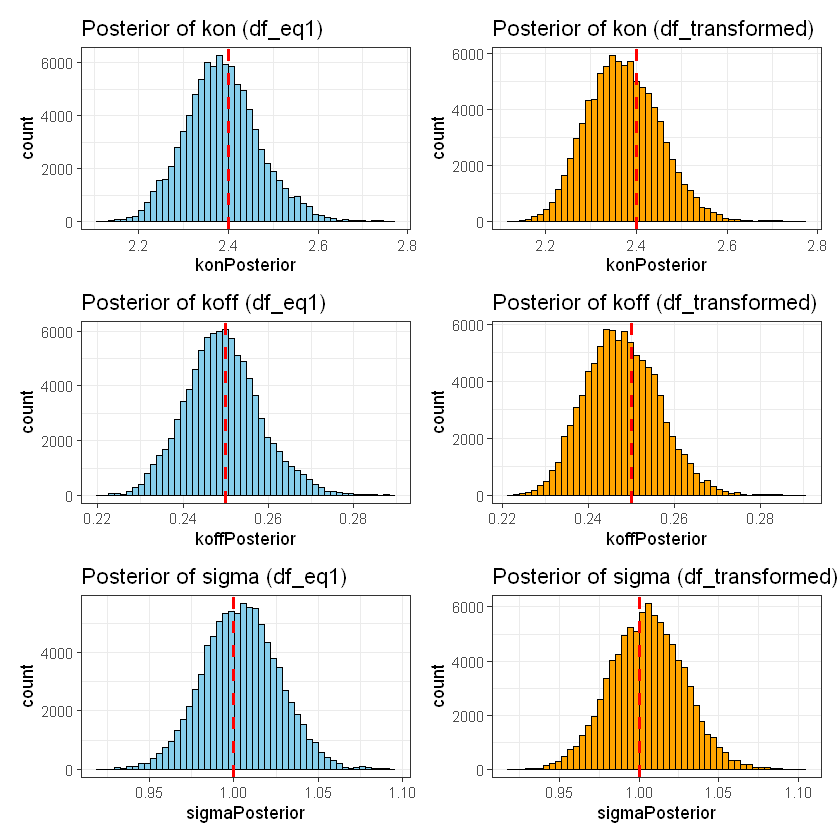

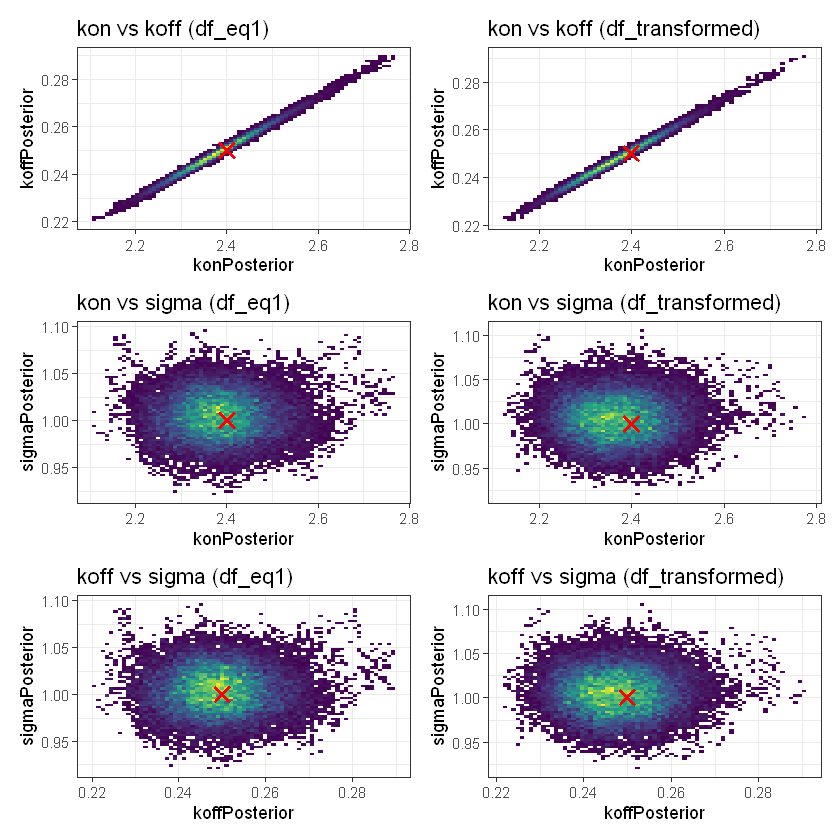

In [30]:
par(bg="white")

# Histograms for df_eq1
hist_kon_eq1 <- ggplot(df_eq1, aes(konPosterior)) + 
  geom_histogram(bins = 50, fill = "skyblue", color = "black") +
  geom_vline(xintercept = kon_gt, color = "red", linetype = "dashed", size = 1) +
  ggtitle("Posterior of kon (df_eq1)") +
  theme_bw()

hist_koff_eq1 <- ggplot(df_eq1, aes(koffPosterior)) + 
  geom_histogram(bins = 50, fill = "skyblue", color = "black") +
  geom_vline(xintercept = koff_gt, color = "red", linetype = "dashed", size = 1) +
  ggtitle("Posterior of koff (df_eq1)") +
  theme_bw()

hist_sigma_eq1 <- ggplot(df_eq1, aes(sigmaPosterior)) + 
  geom_histogram(bins = 50, fill = "skyblue", color = "black") +
  geom_vline(xintercept = sigma_gt, color = "red", linetype = "dashed", size = 1) +
  ggtitle("Posterior of sigma (df_eq1)") +
  theme_bw()


# Histograms for df_transformed
hist_kon_trans <- ggplot(df_transformed, aes(konPosterior)) + 
  geom_histogram(bins = 50, fill = "orange", color = "black") +
  geom_vline(xintercept = kon_gt, color = "red", linetype = "dashed", size = 1) +
  ggtitle("Posterior of kon (df_transformed)") +
  theme_bw()

hist_koff_trans <- ggplot(df_transformed, aes(koffPosterior)) + 
  geom_histogram(bins = 50, fill = "orange", color = "black") +
  geom_vline(xintercept = koff_gt, color = "red", linetype = "dashed", size = 1) +
  ggtitle("Posterior of koff (df_transformed)") +
  theme_bw()

hist_sigma_trans <- ggplot(df_transformed, aes(sigmaPosterior)) + 
  geom_histogram(bins = 50, fill = "orange", color = "black") +
  geom_vline(xintercept = sigma_gt, color = "red", linetype = "dashed", size = 1) +
  ggtitle("Posterior of sigma (df_transformed)") +
  theme_bw()


# 2D histograms df_eq1
gt_df <- data.frame(kon = kon_gt, koff = koff_gt, sigma = sigma_gt)

plot_kon_koff_eq1 <- ggplot(df_eq1, aes(x = konPosterior, y = koffPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = kon, y = koff), color = "red", shape = 4, size = 3, stroke = 1.5) +
  ggtitle("kon vs koff (df_eq1)") +
  theme_bw()

plot_kon_sigma_eq1 <- ggplot(df_eq1, aes(x = konPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = kon, y = sigma), color = "red", shape = 4, size = 3, stroke = 1.5) +
  ggtitle("kon vs sigma (df_eq1)") +
  theme_bw()

plot_koff_sigma_eq1 <- ggplot(df_eq1, aes(x = koffPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df, aes(x = koff, y = sigma), color = "red", shape = 4, size = 3, stroke = 1.5) +
  ggtitle("koff vs sigma (df_eq1)") +
  theme_bw()


# 2D histograms df_transformed
gt_df_transformed <- data.frame(kon = kon_gt, koff = koff_gt, sigma = sigma_gt)

plot_kon_koff_trans <- ggplot(df_transformed, aes(x = konPosterior, y = koffPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df_transformed, aes(x = kon, y = koff), color = "red", shape = 4, size = 3, stroke = 1.5) +
  ggtitle("kon vs koff (df_transformed)") +
  theme_bw()

plot_kon_sigma_trans <- ggplot(df_transformed, aes(x = konPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df_transformed, aes(x = kon, y = sigma), color = "red", shape = 4, size = 3, stroke = 1.5) +
  ggtitle("kon vs sigma (df_transformed)") +
  theme_bw()

plot_koff_sigma_trans <- ggplot(df_transformed, aes(x = koffPosterior, y = sigmaPosterior)) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  geom_point(data = gt_df_transformed, aes(x = koff, y = sigma), color = "red", shape = 4, size = 3, stroke = 1.5) +
  ggtitle("koff vs sigma (df_transformed)") +
  theme_bw()

# Arrange histograms side-by-side (3 rows, 2 columns)
(hist_kon_eq1 | hist_kon_trans) / 
(hist_koff_eq1 | hist_koff_trans) / 
(hist_sigma_eq1 | hist_sigma_trans) + 
  plot_layout(guides = "collect") & theme(legend.position = "bottom")

# Arrange 2D histograms side-by-side (3 rows, 2 columns)
(plot_kon_koff_eq1 | plot_kon_koff_trans) /
(plot_kon_sigma_eq1 | plot_kon_sigma_trans) /
(plot_koff_sigma_eq1 | plot_koff_sigma_trans) + 
  plot_layout(guides = "collect") & theme(legend.position = "side")


Visually it seems that:
- neither posterior estimate is that different from each other in terms of tightness of distribution, by visually looking at the width of the "normal" distributions.
- The equation 1 estimates seem closer to the ground truth compared to the transformed case.
